# Zadanie domowe 3
## WUM

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix
from sklearn.model_selection import KFold, train_test_split

In [30]:
data = pd.read_csv('train.csv')

In [31]:
data.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [32]:
data.shape

(647054, 7)

In [33]:
data.isna().sum().sum()

9619

In [34]:
data = data.loc[data.isna().sum(axis=1)==0,:]

In [35]:
print(np.sort(data.TripType.unique()))
print(data.TripType.unique().shape)

[  3   4   5   6   7   8   9  12  14  15  18  19  20  21  22  23  24  25
  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44 999]
(38,)


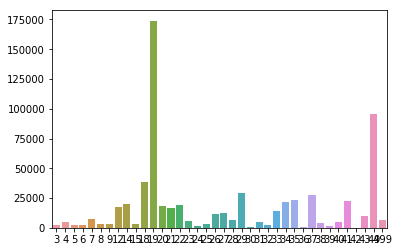

In [36]:
sns.barplot(data.TripType.unique(),data.groupby('TripType').size())
plt.show()

In [37]:
(data.groupby('VisitNumber').nunique().TripType != 1).sum()

0

Dla każdej wizyty w sklepie jest tylko jeden $TripType$

Z początku będziemy rozpatrywac bez VisitNumber, a następnie dla danego VisitNumber wybierzemy modę, bo dany visitnumber ma tylko jeden triptype.

In [38]:
data.groupby('VisitNumber').size().mean()

6.821702547561196

In [39]:
np.mean(data.TripType==999)

0.02681183652836645

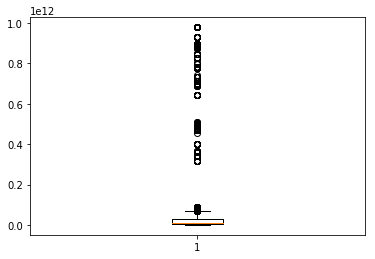

In [40]:
plt.boxplot(data.Upc)
plt.show()

Zlogarytmowanie Upc

In [41]:
data.Upc = np.log(data.Upc)

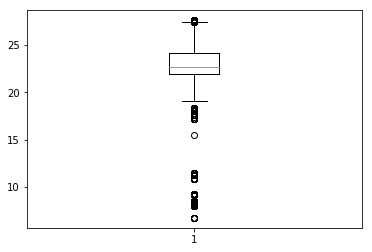

In [42]:
plt.boxplot(data.Upc)
plt.show()

### Encoding

In [43]:
from sklearn.preprocessing import OrdinalEncoder

In [44]:
oe = OrdinalEncoder(categories=[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']])
data.Weekday = oe.fit_transform(data.Weekday.values.reshape((-1,1)))

In [45]:
data_enc = pd.get_dummies(data, columns=['DepartmentDescription'])

In [46]:
data_enc.shape

(642925, 74)

In [47]:
data_enc.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,FinelineNumber,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,...,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS
0,999,5,4.0,24.944436,-1,1000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30,7,4.0,24.826551,1,8931.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,30,7,4.0,22.726206,1,4504.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,26,8,4.0,21.529029,2,3565.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,26,8,4.0,21.419714,2,1017.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


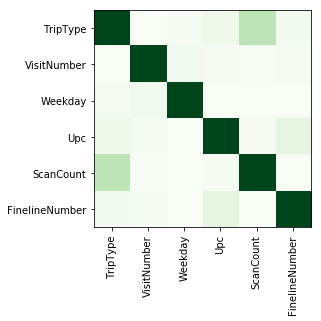

In [48]:
plt.imshow(data_enc.iloc[:,:6].corr().abs(), cmap=plt.cm.Greens)
plt.xticks(np.arange(6),data_enc.iloc[:,:6].columns, rotation=90)
plt.yticks(np.arange(6),data_enc.iloc[:,:6].columns)
plt.show()

In [49]:
data_enc.isna().sum().sum()

0

In [50]:
data_enc.shape

(642925, 74)

### Funkcja do testowania

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [98]:
def test(data, classifier, departments=False):
    
    if departments:
        X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['TripType','VisitNumber']), data.TripType)
    else:
        X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['TripType','DepartmentDescription','VisitNumber']), data.TripType)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    print(accuracy_score(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    plt.show()

### Feature importance with departments

In [53]:
X_train, X_test, y_train, y_test = train_test_split(data_enc.drop(columns=['TripType', 'VisitNumber']), data_enc.TripType)

In [54]:
RFC = RandomForestClassifier(1000, max_depth=3, n_jobs=2)
RFC.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [55]:
y_pred = RFC.predict(X_test)

In [56]:
accuracy_score(y_test, y_pred)

0.28546897941915733

In [57]:
data_enc.columns[RFC.feature_importances_.argsort()]

Index(['DepartmentDescription_LIQUOR,WINE,BEER',
       'DepartmentDescription_CELEBRATION',
       'DepartmentDescription_OFFICE SUPPLIES',
       'DepartmentDescription_PHARMACY OTC',
       'DepartmentDescription_GROCERY DRY GOODS',
       'DepartmentDescription_BOYS WEAR',
       'DepartmentDescription_BOOKS AND MAGAZINES',
       'DepartmentDescription_PRODUCE', 'DepartmentDescription_SEASONAL',
       'DepartmentDescription_INFANT CONSUMABLE HARDLINES',
       'DepartmentDescription_PETS AND SUPPLIES',
       'DepartmentDescription_FINANCIAL SERVICES',
       'DepartmentDescription_OPTICAL - LENSES',
       'DepartmentDescription_OPTICAL - FRAMES',
       'DepartmentDescription_MEDIA AND GAMING',
       'DepartmentDescription_PHARMACY RX', 'DepartmentDescription_BEAUTY',
       'ScanCount', 'FinelineNumber',
       'DepartmentDescription_LARGE HOUSEHOLD GOODS',
       'DepartmentDescription_LADIES SOCKS', 'DepartmentDescription_HARDWARE',
       'DepartmentDescription_SHEER HOSIE

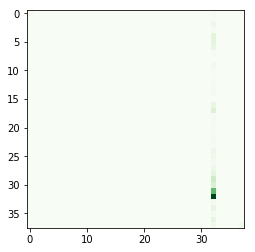

In [58]:
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.show()

### Feature importance bez departments

In [60]:
data2 = data

In [61]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(data2.drop(columns=['TripType','DepartmentDescription','VisitNumber']), data2.TripType)

In [62]:
RFC2 = RandomForestClassifier(1000, max_depth=3, n_jobs=2)
RFC2.fit(X_train2, y_train2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [63]:
y_pred2 = RFC2.predict(X_test2)

In [64]:
accuracy_score(y_test2, y_pred2)

0.2906826269815594

In [65]:
data.columns[RFC2.feature_importances_.argsort()]

Index(['TripType', 'Upc', 'VisitNumber', 'Weekday'], dtype='object')

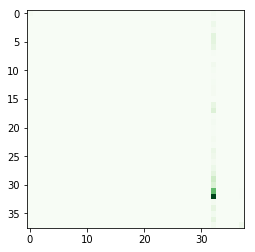

In [66]:
cm = confusion_matrix(y_test2, y_pred2)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.show()

Model lepiej sobie radzi bez departments

# Feature engineering

### Dodanie weekendu

In [68]:
data['weekend'] = (data.Weekday == 5) | (data.Weekday == 6)

0.28724833884976236


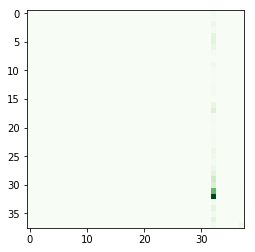

In [69]:
test(data, RandomForestClassifier(1000, max_depth=3, n_jobs=2))

### Kategoryzacja Upc

In [70]:
bins = pd.cut(data.Upc,bins=20, labels=np.arange(20), include_lowest=True)
bins = bins.astype(int)

In [71]:
data.Upc = bins

0.2877025110121196


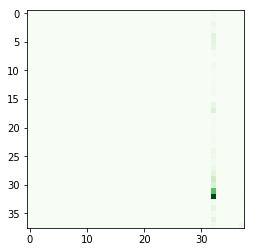

In [72]:
test(data, RandomForestClassifier(1000, max_depth=3, n_jobs=2))

### Przenumerowanie DepartmentDescription względem liczności

In [91]:
data.groupby('TripType').DepartmentDescription.agg(lambda x: x.mode())

TripType
3                        FINANCIAL SERVICES
4                              PHARMACY OTC
5                              PHARMACY OTC
6                          LIQUOR,WINE,BEER
7                              SERVICE DELI
8                               DSD GROCERY
9                                 MENS WEAR
12     [DSD GROCERY, HOUSEHOLD PAPER GOODS]
14                       FABRICS AND CRAFTS
15                              CELEBRATION
18                                     TOYS
19                              ELECTRONICS
20                               AUTOMOTIVE
21                       FABRICS AND CRAFTS
22                              ELECTRONICS
23                  PLAYERS AND ELECTRONICS
24                            COOK AND DINE
25                                MENS WEAR
26                                 HARDWARE
27                          LAWN AND GARDEN
28                           SPORTING GOODS
29                                     TOYS
30                     

In [92]:
dep = data.groupby('DepartmentDescription').size().sort_values().index
dict = dict([(key, i) for i,key in enumerate(dep)])

In [95]:
data.DepartmentDescription = data.DepartmentDescription.map(dict)

0.2881504616380061


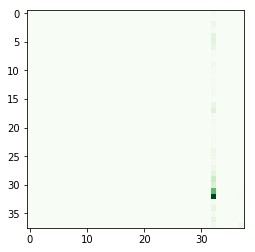

In [99]:
test(data, RandomForestClassifier(1000, max_depth=3, n_jobs=2), True)

# Podsumowanie

Dodanie nowych cech jest w stanie nieznacznie poprawić działanie modelu. Mimo wszystko model, z uwagi na duże zróżnicowanie klas, skupia sie po prostu na klasyfikowaniu jednej klasy.